Reloading Tuner from tuner_dir\music_recognition_tuning\tuner0.json

The hyperparameter search is complete. The optimal number of units in the first layer is 448.
The optimal number of units in the second layer is 128.
The optimal number of units in the third layer is 32.
The optimal dropout rate for the first layer is 0.30000000000000004.
The optimal dropout rate for the second layer is 0.1.
The optimal dropout rate for the third layer is 0.0.
The optimal optimizer is adam.

Epoch 1/50
7405/7405 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.6429 - loss: 1.4135 - val_accuracy: 0.9195 - val_loss: 0.2705
Epoch 2/50
7405/7405 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.9001 - loss: 0.3294 - val_accuracy: 0.9395 - val_loss: 0.1980
Epoch 3/50
7405/7405 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.9200 - loss: 0.2622 - val_accuracy: 0.9481 - val_loss: 0.1688
Epoch 4/50
7405/7405 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.9282 - loss: 0.2396 - val_accuracy: 0.9557 - val_loss: 0.

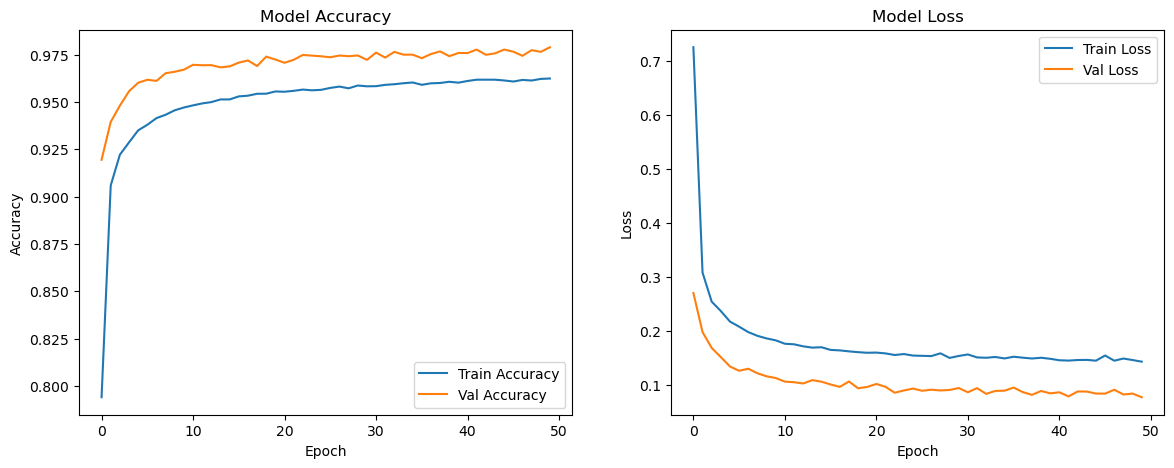

1852/1852 ━━━━━━━━━━━━━━━━━━━━ 2s 898us/step


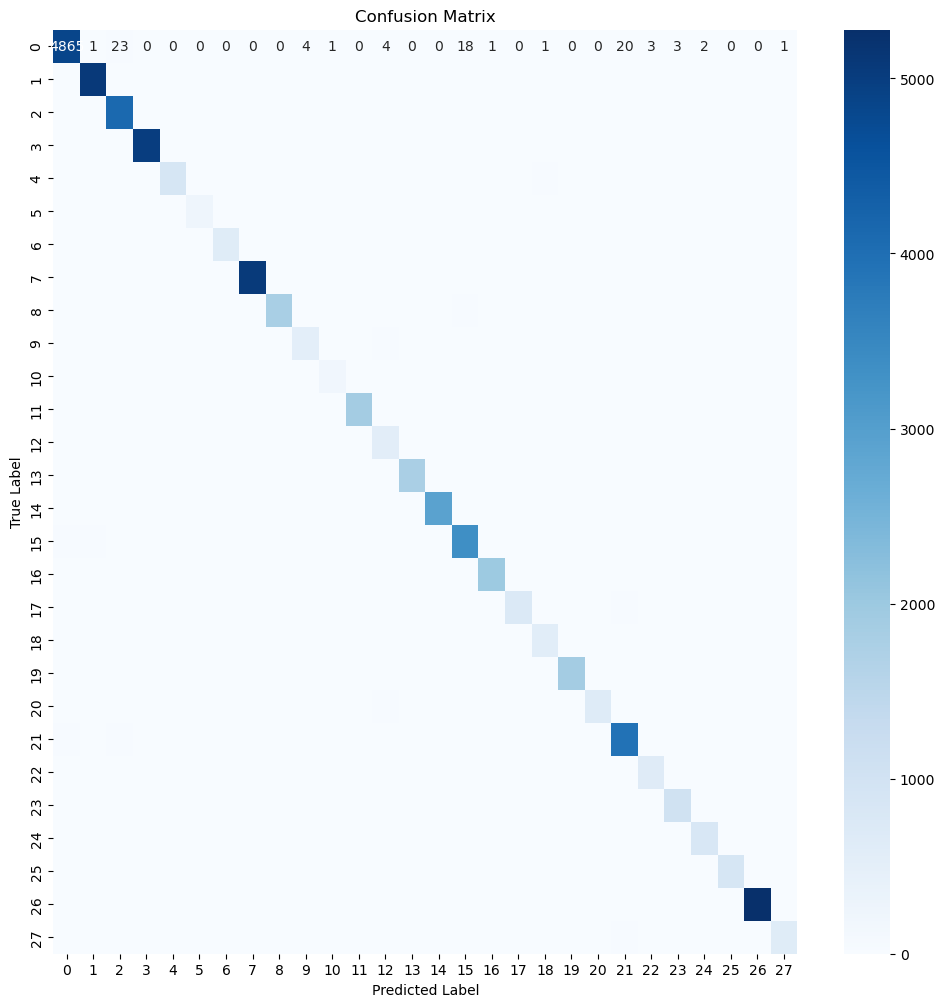

Classification Report:
                 precision    recall  f1-score   support

      Accordion       0.97      0.98      0.98      4947
Acoustic_Guitar       0.99      0.98      0.99      5167
          Banjo       0.97      0.98      0.98      4180
    Bass_Guitar       1.00      1.00      1.00      5013
       Clarinet       0.98      0.94      0.96       923
        Cymbals       0.93      0.81      0.87       285
          Dobro       0.96      0.95      0.96       656
       Drum_set       1.00      1.00      1.00      5060
 Electro_Guitar       0.99      0.96      0.98      1862
      Floor_Tom       0.92      0.92      0.92       577
      Harmonica       0.99      0.96      0.97       202
      Harmonium       1.00      1.00      1.00      1888
        Hi_Hats       0.81      0.92      0.86       605
           Horn       1.00      1.00      1.00      1781
       Keyboard       1.00      1.00      1.00      2910
       Mandolin       0.97      0.98      0.97      3434
       

In [2]:
import os
import librosa
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
import kerastuner as kt
import warnings

warnings.filterwarnings("ignore")

def load_data(dataset_path, augment=False):
    labels = []
    features = []

    for subdir, dirs, files in os.walk(dataset_path):
        for file in files:
            file_path = os.path.join(subdir, file)
            y, sr = librosa.load(file_path, duration=3.0)
            mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
            mfcc_scaled = np.mean(mfcc.T, axis=0)
            features.append(mfcc_scaled)
            label = os.path.basename(subdir)
            labels.append(label)

            if augment:
                # Time Stretching
                y_stretch = librosa.effects.time_stretch(y, rate=0.8)
                mfcc_stretch = librosa.feature.mfcc(y=y_stretch, sr=sr, n_mfcc=40)
                mfcc_stretch_scaled = np.mean(mfcc_stretch.T, axis=0)
                features.append(mfcc_stretch_scaled)
                labels.append(label)

                y_stretch = librosa.effects.time_stretch(y, rate=1.2)
                mfcc_stretch = librosa.feature.mfcc(y=y_stretch, sr=sr, n_mfcc=40)
                mfcc_stretch_scaled = np.mean(mfcc_stretch.T, axis=0)
                features.append(mfcc_stretch_scaled)
                labels.append(label)

                # Pitch Shifting
                y_shift = librosa.effects.pitch_shift(y, sr=sr, n_steps=2)
                mfcc_shift = librosa.feature.mfcc(y=y_shift, sr=sr, n_mfcc=40)
                mfcc_shift_scaled = np.mean(mfcc_shift.T, axis=0)
                features.append(mfcc_shift_scaled)
                labels.append(label)

                y_shift = librosa.effects.pitch_shift(y, sr=sr, n_steps=-2)
                mfcc_shift = librosa.feature.mfcc(y=y_shift, sr=sr, n_mfcc=40)
                mfcc_shift_scaled = np.mean(mfcc_shift.T, axis=0)
                features.append(mfcc_shift_scaled)
                labels.append(label)

                # Adding Noise
                noise = np.random.randn(len(y))
                y_noise = y + 0.005 * noise
                mfcc_noise = librosa.feature.mfcc(y=y_noise, sr=sr, n_mfcc=40)
                mfcc_noise_scaled = np.mean(mfcc_noise.T, axis=0)
                features.append(mfcc_noise_scaled)
                labels.append(label)

                # Shifting Time
                y_roll = np.roll(y, 1600)
                mfcc_roll = librosa.feature.mfcc(y=y_roll, sr=sr, n_mfcc=40)
                mfcc_roll_scaled = np.mean(mfcc_roll.T, axis=0)
                features.append(mfcc_roll_scaled)
                labels.append(label)

    return np.array(features), np.array(labels)

dataset_path = r"C:\Users\offic\OneDrive\Masaüstü\datasets\music_dataset"
X, y = load_data(dataset_path, augment=True)

le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_categorical = to_categorical(y_encoded)

X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=42)

def build_model(hp):
    model = Sequential()
    model.add(Dense(units=hp.Int('units_layer_1', min_value=64, max_value=512, step=64), input_shape=(40,), activation='relu'))
    model.add(Dropout(rate=hp.Float('dropout_rate_1', min_value=0.0, max_value=0.5, step=0.1)))
    model.add(Dense(units=hp.Int('units_layer_2', min_value=64, max_value=512, step=64), activation='relu'))
    model.add(Dropout(rate=hp.Float('dropout_rate_2', min_value=0.0, max_value=0.5, step=0.1)))
    model.add(Dense(units=hp.Int('units_layer_3', min_value=32, max_value=256, step=32), activation='relu'))
    model.add(Dropout(rate=hp.Float('dropout_rate_3', min_value=0.0, max_value=0.5, step=0.1)))
    model.add(Dense(28, activation='softmax'))
    model.compile(optimizer=hp.Choice('optimizer', values=['adam', 'rmsprop']),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=2,
    directory='tuner_dir',
    project_name='music_recognition_tuning'
)

tuner.search(X_train, y_train, epochs=50, validation_data=(X_test, y_test))

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first layer is {best_hps.get('units_layer_1')}.
The optimal number of units in the second layer is {best_hps.get('units_layer_2')}.
The optimal number of units in the third layer is {best_hps.get('units_layer_3')}.
The optimal dropout rate for the first layer is {best_hps.get('dropout_rate_1')}.
The optimal dropout rate for the second layer is {best_hps.get('dropout_rate_2')}.
The optimal dropout rate for the third layer is {best_hps.get('dropout_rate_3')}.
The optimal optimizer is {best_hps.get('optimizer')}.
""")

best_model = build_model(best_hps)

history = best_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

test_loss, test_accuracy = best_model.evaluate(X_test, y_test, verbose=2)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Plot accuracy and loss
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Confusion Matrix
y_pred = best_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Classification Report
class_report = classification_report(y_true, y_pred_classes, target_names=le.classes_)
print('Classification Report:')
print(class_report)
